## 获取日K数据

In [3]:
from utils import get_daily_data,get_local_daily_data,get_local_adjustment_data

local_daily_pd = get_local_daily_data()
local_adjustment_pd = get_local_adjustment_data()
data_pd, adjustment_pd = get_daily_data("002385", local_daily_pd, local_adjustment_pd)

data_pd.tail(3)

,timestamp,datetime,symbol,name,open,high,low,close,preClose,volume,amount,suspendFlag
4844879,1640880000000,2021-12-31 00:00:00,002385.SZ,大北农,10.33,10.71,10.17,10.49,10.35,1074068,1.127795e+09,0
5143457,1733414400000,2024-12-06 00:00:00,002385.SZ,大北农,4.57,4.62,4.53,4.61,4.55,481593,2.209176e+08,0
5143458,1733673600000,2024-12-09 00:00:00,002385.SZ,大北农,4.64,4.67,4.55,4.58,4.61,544267,2.507797e+08,0


## 获取前复权数据

In [5]:
from utils import get_forward_data,get_local_daily_data,get_local_adjustment_data

local_daily_pd = get_local_daily_data()
local_adjustment_pd = get_local_adjustment_data()
data_pd = get_forward_data("002385", local_daily_pd, local_adjustment_pd)

data_pd.tail(3)

,datetime,symbol,name,open,high,low,close,volume,amount,suspendFlag
223,2024-12-05 00:00:00,002385.SZ,大北农,4.56,4.59,4.52,4.55,368190,169554993.0,0
951,2024-12-06 00:00:00,002385.SZ,大北农,4.57,4.62,4.53,4.61,481593,220917578.0,0
952,2024-12-09 00:00:00,002385.SZ,大北农,4.64,4.67,4.55,4.58,544267,250779674.0,0


## 计算指标

计算指标放在`indicator`目录下

In [6]:
from utils import get_forward_data,get_local_daily_data,get_local_adjustment_data
from indicator import macd

local_daily_pd = get_local_daily_data()
local_adjustment_pd = get_local_adjustment_data()
data_pd = get_forward_data("002385", local_daily_pd, local_adjustment_pd)

# 删除停牌数据
data_pd = data_pd[data_pd['suspendFlag'] == 0]
data_pd.drop(columns='suspendFlag', inplace=True)

data_pd = macd(data_pd)

data_pd.tail(3)

,datetime,symbol,name,open,high,low,close,volume,amount,macd,macd_dea,macd_diff
223,2024-12-05 00:00:00,002385.SZ,大北农,4.56,4.59,4.52,4.55,368190,169554993.0,0.005,0.010,0.012
951,2024-12-06 00:00:00,002385.SZ,大北农,4.57,4.62,4.53,4.61,481593,220917578.0,0.011,0.011,0.016
952,2024-12-09 00:00:00,002385.SZ,大北农,4.64,4.67,4.55,4.58,544267,250779674.0,0.010,0.012,0.017


## 回测

In [ ]:
from utils import get_forward_data,get_local_daily_data,get_local_adjustment_data
from indicator import macd,rsi
import pandas as pd

local_daily_pd = get_local_daily_data()
local_adjustment_pd = get_local_adjustment_data()
data_pd = get_forward_data("002385", local_daily_pd, local_adjustment_pd)

# 删除停牌数据
data_pd = data_pd[data_pd['suspendFlag'] == 0]
data_pd.drop(columns='suspendFlag', inplace=True)

data_pd = macd(data_pd)
data_pd = rsi(data_pd)

data_pd.tail(3)

,datetime,symbol,name,open,high,low,close,volume,amount,macd,macd_dea,macd_diff,rsi
223,2024-12-05 00:00:00,002385.SZ,大北农,4.56,4.59,4.52,4.55,368190,169554993.0,0.005,0.010,0.012,51.291
951,2024-12-06 00:00:00,002385.SZ,大北农,4.57,4.62,4.53,4.61,481593,220917578.0,0.011,0.011,0.016,54.507
952,2024-12-09 00:00:00,002385.SZ,大北农,4.64,4.67,4.55,4.58,544267,250779674.0,0.010,0.012,0.017,52.635


使用pybroker进行回测

[文档](https://www.pybroker.com/zh-cn/latest/install.html)

In [12]:
import pybroker
from pybroker import Strategy,StrategyConfig

In [13]:
data_pd['date'] = pd.to_datetime(data_pd['datetime'])

# 注册指标到pybroker
pybroker.register_columns('rsi')

# 初始化资金:50000元
config = StrategyConfig(initial_cash=50000)

strategy = Strategy(data_pd, '4/1/2021', '09/12/2024',config=config)

In [15]:
# 定义策略
def buy_low_sell_high_rsi(ctx):
    pos = ctx.long_pos()
    if not pos and ctx.rsi[-1] < 30:
        ctx.buy_shares = 100
    elif pos and ctx.rsi[-1] > 70:
        ctx.sell_shares = pos.shares

# 注册策略到pybroker
strategy.add_execution(buy_low_sell_high_rsi, ['002385.SZ'])

In [ ]:
# 回测
result = strategy.backtest()

Backtesting: 2021-04-01 00:00:00 to 2024-09-12 00:00:00

Test split: 2021-04-01 00:00:00 to 2024-09-12 00:00:00


  0% (0 of 840) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (840 of 840) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:01


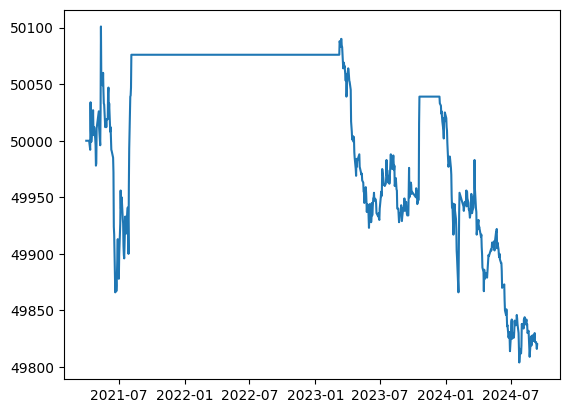

In [21]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])